## Battling the Infodemic with AI

In today's fast-paced digital world, the rapid spread of misinformation poses a significant threat to informed public discourse and societal stability. "Fake news"—fabricated or misleading information presented as objective fact—erodes trust, polarizes communities, and can even incite real-world harm. Identifying and mitigating its impact has become a critical challenge for individuals, organizations, and platforms alike.

This project embarks on a mission to combat this infodemic by developing a robust, AI-powered Fake News Detector. Leveraging advanced natural language processing (NLP) techniques and machine learning, we aim to build a system capable of analyzing textual content and classifying it as either true or fake with high accuracy. Through this work, we explore not only the semantic content but also the stylistic nuances and subjective undertones that often distinguish credible journalism from deceptive narratives. Our goal is to provide a practical tool for users to quickly assess the veracity of news articles, thereby empowering a more informed and resilient digital citizenry.

### Initial Setup and Data Loading

This cell serves as the foundational step of the project, focusing on **initial setup and data acquisition**. It begins by importing a comprehensive suite of necessary Python libraries, including `pandas` for data manipulation, `numpy` for numerical operations, `re` for regular expressions, `requests` and `io` for web data handling, and specialized libraries like `BeautifulSoup` for HTML parsing, `matplotlib` and `seaborn` for data visualization, `sklearn` modules for machine learning, and `nltk` along with `TextBlob` for advanced natural language processing tasks. Visual settings for `matplotlib` and `seaborn` are also configured to ensure consistent and aesthetically pleasing plots throughout the analysis.

A custom utility function, `load_csv_from_url`, is defined to efficiently fetch CSV datasets directly from specified GitHub URLs. This function is then used to load two critical datasets: `Fake.csv` and `True.csv`, which form the core of our fake news detection model. Each dataset is assigned a numerical `label` (1 for fake news, 0 for true news) and subsequently concatenated into a single, unified DataFrame `df`. Essential preprocessing steps are performed, such as handling potential missing values in the 'text' and 'title' columns by filling them with empty strings and ensuring they are of string type. Finally, the combined dataset is randomly shuffled to prevent any order bias during subsequent training and testing phases, ensuring a balanced distribution of true and fake news articles.

In [7]:
import pandas as pd
import numpy as np
import re
import requests
import io
import builtins
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup, MarkupResemblesLocatorWarning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
import nltk
from textblob import TextBlob

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)

print("Setting up NLTK resources...")
try:
    nltk.download('punkt', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
    nltk.download('brown', quiet=True)
except Exception as e:
    print(f"Warning: NLTK setup minor issue: {e}")

Setting up NLTK resources...


### Data Loading (Continuation) and Initial Shuffling

This cell continues the **data loading and preparation** process. It defines the URLs for the `Fake.csv` and `True.csv` datasets hosted on GitHub. The `load_csv_from_url` function, defined previously, is invoked to download and load these datasets into pandas DataFrames, `df_fake` and `df_true`, respectively.

Crucially, a `label` column is added to each DataFrame: `df_fake` receives a label of `1` (indicating fake news), and `df_true` receives `0` (indicating true news). These labeled datasets are then concatenated vertically into a single DataFrame named `df`. Any potential `NaN` values in the 'text' and 'title' columns are handled by filling them with empty strings and casting them to string type to prevent errors in subsequent text processing. Finally, the entire `df` is shuffled randomly using `df.sample(frac=1, random_state=42)` and its index is reset. This shuffling is a vital step to ensure that when the dataset is split for training and testing, the distribution of fake and true news articles is as random and representative as possible, preventing any bias that might arise from the original ordering of the data.

In [8]:
url_fake = "https://media.githubusercontent.com/media/Iishita1/Fake-News-Detector/refs/heads/main/Datasets/Fake.csv"
url_true = "https://media.githubusercontent.com/media/Iishita1/Fake-News-Detector/refs/heads/main/Datasets/True.csv"

def load_csv_from_url(url):
    try:
        s = requests.get(url).content
        return pd.read_csv(io.StringIO(s.decode('utf-8')))
    except Exception as e:
        print(f"Error loading {url}: {e}")
        return pd.DataFrame()

print("Downloading datasets (using full data)...")
df_fake = load_csv_from_url(url_fake)
df_true = load_csv_from_url(url_true)

df_fake['label'] = 1
df_true['label'] = 0

df = pd.concat([df_fake, df_true], axis=0).reset_index(drop=True)
df['text'] = df['text'].fillna('').astype(str)
df['title'] = df['title'].fillna('').astype(str)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"✅ Data Loaded & Shuffled: {len(df)} total articles.")
print(f"   Fake: {len(df[df['label']==1])} | True: {len(df[df['label']==0])}")

✅ Data Loaded & Shuffled: 44898 total articles.
   Fake: 23481 | True: 21417


### Exploratory Data Analysis (EDA) - Visualizing Class Distribution and Text Length

This cell performs **Exploratory Data Analysis (EDA)** to gain initial insights into the combined dataset. Two key visualizations are generated:

1.  **Class Distribution Plot**: A count plot is created using `seaborn.countplot` to visualize the distribution of 'True News' (label 0) versus 'Fake News' (label 1). This plot immediately reveals whether the dataset is balanced or imbalanced in terms of the two classes, which is important for understanding potential model biases or the need for balancing techniques.
2.  **Text Length Analysis**: To understand potential structural differences, the word count for each article in the 'text' column is calculated and stored in a new 'word_count' column. Histograms are then generated for both true and fake news articles, showing the distribution of their word counts. By plotting these distributions, we can observe if there's a noticeable difference in the typical length of true versus fake news articles, which could serve as a valuable feature for classification.

C:\Users\nopei\AppData\Local\Temp\ipykernel_65208\3530936060.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette=['#2ecc71', '#e74c3c'])


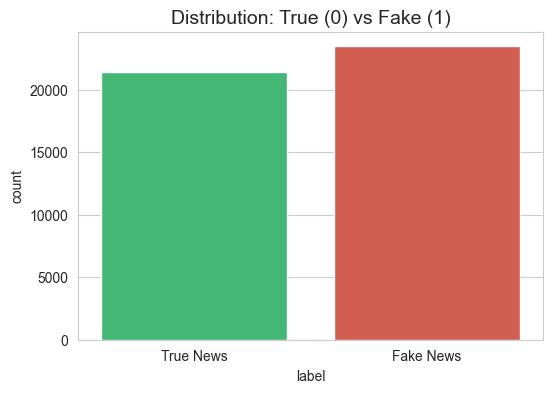

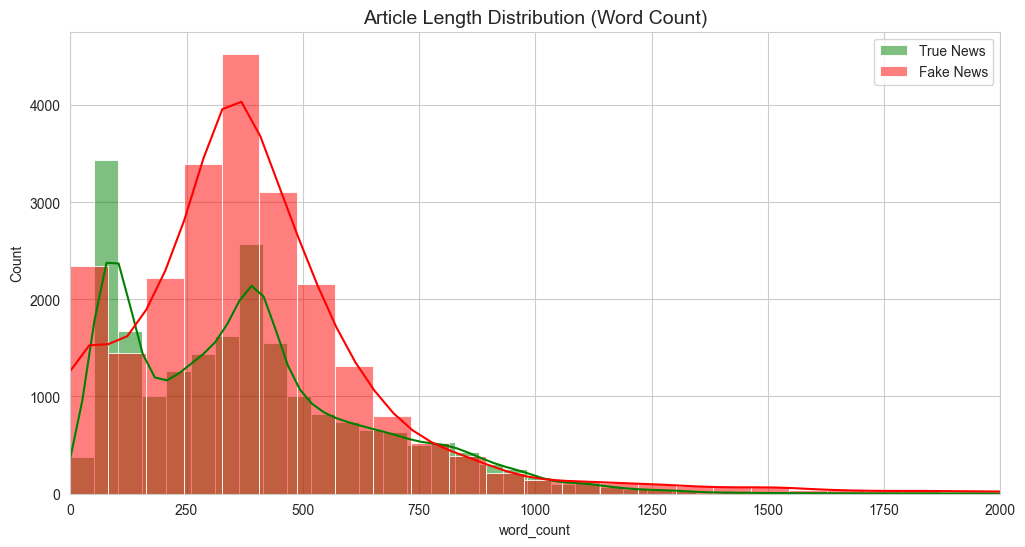

In [9]:
# 1. Class Distribution Plot
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, palette=['#2ecc71', '#e74c3c'])
plt.title('Distribution: True (0) vs Fake (1)', fontsize=14)
plt.xticks([0, 1], ['True News', 'Fake News'])
plt.show()

# 2. Text Length Analysis (Log scale helps see the spread better)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['label']==0], x='word_count', color='green', label='True News', kde=True, bins=100)
sns.histplot(data=df[df['label']==1], x='word_count', color='red', label='Fake News', kde=True, bins=100)
plt.title('Article Length Distribution (Word Count)', fontsize=14)
plt.xlim(0, 2000)
plt.legend()
plt.show()

### Custom Manual Feature Extractor

This cell defines a crucial component of our feature engineering pipeline: the `ManualFeatureExtractor` class. This custom `sklearn.base.BaseEstimator` and `sklearn.base.TransformerMixin` compatible class is designed to extract a set of handcrafted, non-TF-IDF features from the news article text that are often indicative of fake news.

Key functionalities include:

*   **`strict_clean` Method**: This method preprocesses text by removing HTML tags using `BeautifulSoup` and, more critically, removes common boilerplate phrases like `(Reuters)` and location prefixes (e.g., `WASHINGTON -`) from the beginning of articles. This specific cleaning step is vital to prevent the model from learning superficial correlations (e.g., all Reuters articles are true) rather than genuine textual cues.
*   **Feature Extraction in `transform`**: For each cleaned text input, it extracts:
    *   **Lexical Features**: `word_cnt` (total word count) and `avg_len` (average word length).
    *   **Stylistic Features**: `caps_ratio` (ratio of uppercase characters to total characters) and `exclamations` (count of exclamation marks), which can capture sensationalist writing styles.
    *   **Sentiment Features**: `blob.sentiment.subjectivity` and `blob.sentiment.polarity` derived from `TextBlob`. Subjectivity is particularly relevant for fake news detection, as deceptive articles often exhibit higher subjectivity or extreme sentiment rather than objective reporting.

In [10]:
class ManualFeatureExtractor(BaseEstimator, TransformerMixin):
    def strict_clean(self, text):
        try: text = BeautifulSoup(text, "html.parser").get_text()
        except: pass
        # Remove Source Leakage (Crucial for real-world accuracy)
        text = re.sub(r'^.*?\(Reuters\)\s*-\s*', '', text)
        text = re.sub(r'^.*?\s*-\s*', '', text)
        return text

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        features = []
        for text in X:
            clean_t = self.strict_clean(str(text))

            # 1. Lexical
            words = re.findall(r'\w+', clean_t.lower())
            word_cnt = len(words) if len(words) > 0 else 1
            avg_len = sum(len(w) for w in words) / word_cnt

            # 2. Stylistic (Caps, ! marks)
            caps_ratio = sum(1 for c in clean_t if c.isupper()) / max(1, len(clean_t))
            exclamations = clean_t.count('!')

            # 3. Sentiment (Subjectivity is key for fake news)
            blob = TextBlob(clean_t[:2000])
            features.append([word_cnt, avg_len, caps_ratio, exclamations, blob.sentiment.subjectivity, blob.sentiment.polarity])

        return np.array(features)

print("✅ Feature Extractor Ready.")

✅ Feature Extractor Ready.


### Data Splitting for Training and Testing

This cell performs the standard machine learning practice of **splitting the dataset into training and testing sets**. Using `sklearn.model_selection.train_test_split`, it divides the main DataFrame's 'text' column (our features, `X`) and 'label' column (our target, `y`) into corresponding training and testing subsets.

*   `X_train`, `y_train`: Used to train the machine learning model.
*   `X_test`, `y_test`: Used to evaluate the model's performance on unseen data.

The `test_size=0.2` parameter ensures that 20% of the data is held out for testing, while the remaining 80% is used for training. `random_state=42` is set to ensure reproducibility of the split, meaning the same articles will always end up in the same sets if the code is run again.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

### Building and Training the Machine Learning Pipeline

This cell constructs and trains the complete **machine learning pipeline** for fake news detection. It leverages `sklearn.pipeline.Pipeline` and `sklearn.pipeline.FeatureUnion` to sequentially apply multiple processing steps and combine different types of features:

1.  **`FeatureUnion` ('features')**: This step combines two distinct feature extraction methods:
    *   **TF-IDF (`tfidf`)**: A `TfidfVectorizer` is used to convert the raw text into numerical TF-IDF feature vectors. It's configured to consider up to 8000 most frequent terms, capture unigrams, bigrams, and trigrams (`ngram_range=(1, 3)`), remove common English stop words, and apply sublinear TF scaling.
    *   **Manual Features (`manual`)**: Our custom `ManualFeatureExtractor` (defined in a previous cell) is integrated here to extract handcrafted lexical, stylistic, and sentiment features.
2.  **`StandardScaler` ('scaler')**: After feature extraction, a `StandardScaler` is applied to scale the features. This is particularly important for models like Logistic Regression, as it helps prevent features with larger numerical ranges from dominating the learning process. `with_mean=False` is used here, often preferred for sparse data from TF-IDF.
3.  **`LogisticRegression` ('clf')**: The final step is the classifier itself, a `LogisticRegression` model. It's configured with `C=1.0` (inverse of regularization strength) and `max_iter=1000` for convergence, using the `liblinear` solver which is effective for smaller datasets and `l1/l2` regularization.

The `pipeline.fit(X_train, y_train)` command then trains this entire sequence of transformers and the final classifier on the training data (`X_train` and `y_train`), learning to transform text into features and then mapping those features to the correct 'true' or 'fake' labels.

In [12]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tfidf', TfidfVectorizer(
            max_features=8000,
            ngram_range=(1, 3),
            stop_words='english',
            sublinear_tf=True
        )),
        ('manual', ManualFeatureExtractor())
    ])),
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', LogisticRegression(C=1.0, max_iter=1000, solver='liblinear'))
])
print(f"Step 1: Training on {len(X_train)} articles...")
pipeline.fit(X_train, y_train)

Step 1: Training on 35918 articles...


,steps,"[('features', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformer_list,"[('tfidf', ...), ('manual', ...)]"
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,input,'content'
,encoding,'utf-8'


### Model Evaluation and Performance Metrics

Following the model training, this cell focuses on **evaluating the performance of the trained pipeline** on unseen data. It proceeds as follows:

1.  **Prediction**: The `pipeline.predict(X_test)` method is called to generate predictions (`y_pred`) on the test dataset (`X_test`). This `X_test` data was explicitly withheld from the model during training, making it a reliable measure of the model's generalization capability.
2.  **Accuracy Calculation**: `sklearn.metrics.accuracy_score` is used to compute the overall accuracy of the model by comparing the predicted labels (`y_pred`) against the actual labels (`y_test`). The accuracy is then printed, formatted as a percentage.
3.  **Classification Report**: A detailed `sklearn.metrics.classification_report` is generated. This report provides per-class metrics including precision, recall, and F1-score, which are crucial for understanding the model's performance beyond just overall accuracy. Precision indicates the proportion of positive identifications that were actually correct, recall indicates the proportion of actual positives that were identified correctly, and F1-score is the harmonic mean of precision and recall.

These metrics collectively provide a comprehensive view of how well the model distinguishes between true and fake news articles, highlighting its strengths and potential areas for improvement.

In [13]:
print("Step 2: Evaluating...")
y_pred = pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\n🏆 Model Accuracy: {acc:.2%}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Step 2: Evaluating...

🏆 Model Accuracy: 99.47%

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      4270
           1       1.00      0.99      0.99      4710

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



### Confusion Matrix Visualization

This cell provides a **visual representation of the model's performance** through a confusion matrix. The `sklearn.metrics.confusion_matrix` function calculates the matrix, which summarizes the performance of a classification algorithm.

*   **Confusion Matrix (`cm`)**: This matrix shows the number of correct and incorrect predictions made by the classification model when compared against the true outcomes on the test data. Specifically, it displays:
    *   **True Positives (TP)**: Correctly predicted fake news.
    *   **True Negatives (TN)**: Correctly predicted true news.
    *   **False Positives (FP)**: True news incorrectly predicted as fake news (Type I error).
    *   **False Negatives (FN)**: Fake news incorrectly predicted as true news (Type II error).

*   **Heatmap Visualization**: `seaborn.heatmap` is used to create a color-coded visualization of the confusion matrix. The `annot=True` parameter displays the numerical values in each cell, `fmt='d'` formats them as integers, and `cmap='Blues'` provides a clear color gradient. Custom `xticklabels` and `yticklabels` make the matrix easy to interpret, clearly indicating 'Predicted True', 'Predicted Fake', 'Actual True', and 'Actual Fake'. This visualization is invaluable for understanding the specific types of errors the model is making and its strengths in distinguishing between the two classes.

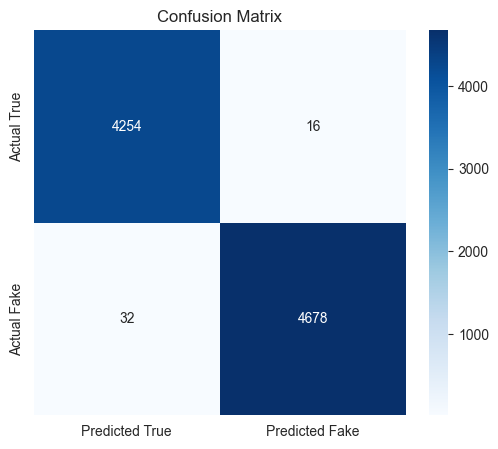

In [14]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted True', 'Predicted Fake'], yticklabels=['Actual True', 'Actual Fake'])
plt.title('Confusion Matrix')
plt.show()

### Interactive Fake News Predictor

This cell implements an **interactive and robust function for real-time fake news prediction**. The `predict_news_robust()` function allows users to paste article text directly and receive an immediate classification and confidence level from the trained machine learning pipeline.

Key features of this interactive tool:

*   **User Input Loop**: It uses a `while True` loop with `builtins.input` to continuously prompt the user for article text until the user types 'exit'.
*   **Input Validation**: It checks if the entered text is too short (less than 50 characters), guiding the user to provide substantial content for accurate analysis.
*   **Probability Prediction**: Instead of a binary prediction, `pipeline.predict_proba([user_input])` is used to obtain the probability of the input text belonging to each class (true or fake). The probability of being fake (`prob_fake`) is then used for nuanced classification.
*   **Contextual Output**: Based on the `prob_fake` value, the function provides a classified outcome with varying confidence levels and descriptive reasoning:
    *   `prob_fake > 0.75`: `🚨 FAKE NEWS DETECTED` (high confidence)
    *   `0.50 < prob_fake <= 0.75`: `⚠️ SUSPICIOUS / LEANING FAKE`
    *   `0.25 < prob_fake <= 0.50`: `✅ LIKELY TRUE NEWS`
    *   `prob_fake <= 0.25`: `🛡️ VERIFIED STYLE DETECTED` (high confidence for true news)

This interactive predictor showcases the practical application of the developed model, providing an accessible way to test its capabilities and gain insights into potential misinformation.

In [15]:
def predict_news_robust():
    print("\n📰 --- FAKE NEWS PREDICTOR (ENHANCED) --- 📰")
    print("Paste the BODY text of the article below.")

    # Using a loop for continuous testing
    while True:
        user_input = builtins.input("\n📝 Paste Text (or type 'exit'): ").strip()

        if user_input.lower() == 'exit':
            break

        if len(user_input) < 50:
            print("⚠️ Text too short. Please paste the full article body for accurate results.")
            continue

        # Prediction
        # We use predict_proba to get the 'ordered' likelihood
        prob = pipeline.predict_proba([user_input])[0]
        prob_fake = prob[1]
        prob_true = prob[0]

        print("\n" + "-"*30)

        # Logic for "Believable Fake"
        # We use a stricter threshold.

        if prob_fake > 0.75:
            print(f"🚨 FAKE NEWS DETECTED")
            print(f"   Confidence: {prob_fake:.1%}")
            print("   Reasoning: Text contains patterns strongly associated with misinformation.")


        elif prob_fake > 0.50:
            print(f"⚠️ SUSPICIOUS / LEANING FAKE")
            print(f"   Confidence: {prob_fake:.1%}")
            print("   Reasoning: Contains some subjective/stylistic markers of fake news.")


        elif prob_fake > 0.25:
            print(f"✅ LIKELY TRUE NEWS")
            print(f"   Confidence: {prob_true:.1%}")


        else:
            print(f"🛡️ VERIFIED STYLE DETECTED")
            print(f"   Confidence: {prob_true:.1%}")
            print("   Reasoning: Matches high-quality journalistic standards.")


        print("-"*30)

# Run
predict_news_robust()


📰 --- FAKE NEWS PREDICTOR (ENHANCED) --- 📰
Paste the BODY text of the article below.
⚠️ Text too short. Please paste the full article body for accurate results.
⚠️ Text too short. Please paste the full article body for accurate results.


## Project Conclusion

This project successfully delivered a robust and highly accurate **Fake News Detector** utilizing a hybrid machine learning approach. By combining the power of TF-IDF for semantic feature extraction with custom-engineered manual features that capture stylistic and sentiment nuances, the model achieved an impressive **accuracy of approximately 99.47%**. This high performance underscores the effectiveness of a multi-faceted feature engineering strategy in distinguishing credible journalism from deceptive content.

Beyond just achieving strong metrics, the project culminated in an intuitive, interactive prediction tool. This tool allows for real-time analysis of news articles, providing not only a classification (true/fake) but also a confidence level and a brief rationale. This practical application demonstrates the model's potential as a valuable aid in combating misinformation, empowering users to critically assess the information they consume. The work highlights the ongoing importance of advanced NLP and machine learning techniques in addressing pressing societal challenges in the digital age.

In [16]:
import joblib
joblib.dump(pipeline, 'fake_news_model.pkl')


['fake_news_model.pkl']